# 2、使用梯度上升法求解主成分

In [1]:
import numpy as np
import matplotlib.pyplot as plt

两个特征有线性关系，使用 PCA 的效果会比较好。

In [2]:
# 100 个数组，每一个数据有 2 个特征
X = np.empty((100, 2))
# 所有的数据的第 1 个特征（可以使用 linspace 等差数列，也可以使用均匀分布，其实是一样的）
X[:, 0] = np.random.uniform(0., 100., size=100)
# 所有的数据的第 2 个特征
X[:, 1] = 0.75 * X[:, 0] + 3. + np.random.normal(0, 10., size=100)

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['STHeiti'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


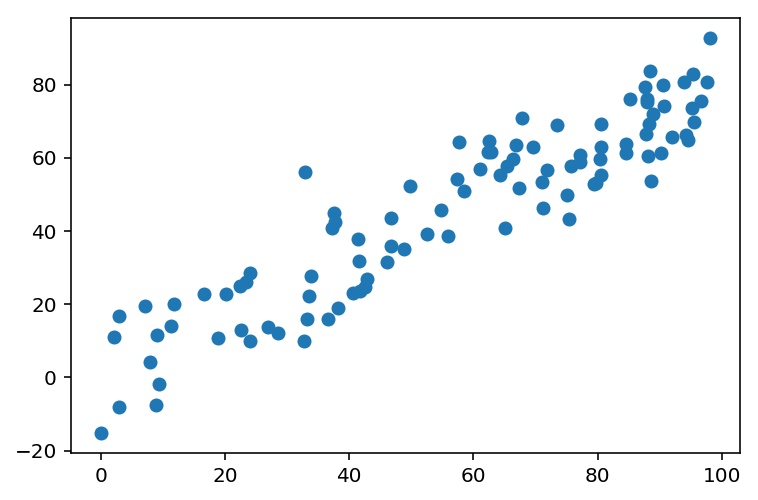

In [3]:
plt.scatter(X[:, 0], X[:, 1])
plt.show()

## demean 

** 对于数据集矩阵的每一个特征，减去这个特征的均值。 **

+ 这一步也叫做“特征归零化”。
+ PCA 是一个无监督学习算法，所以这里的数据集不区分训练数据集和测试数据集。

In [4]:
def demean(X):
    # np.mean(X, axis=0) 计算得到每一列的均值，得到的是一个行向量
    # 求每个特征的平均值才有实际意义
    return X - np.mean(X, axis=0)

---
### 对于 np.mean 的参数 axis 的说明

In [6]:
a = np.arange(12).reshape(2, 6)
a

array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10, 11]])

`axis = 0` 表示压缩行，即不管有多少行，你在行的方向上就只能看到一个数据，所以是对每一列求和。

In [7]:
np.sum(a, axis=0)

array([ 6,  8, 10, 12, 14, 16])

`axis = 1` 表示压缩列，即不管有多少列，你在列的方向上就只能看到一个数据，所以是对每一行求和。

In [9]:
np.sum(a, axis=1)

array([15, 51])

---

In [10]:
X_demean = demean(X)

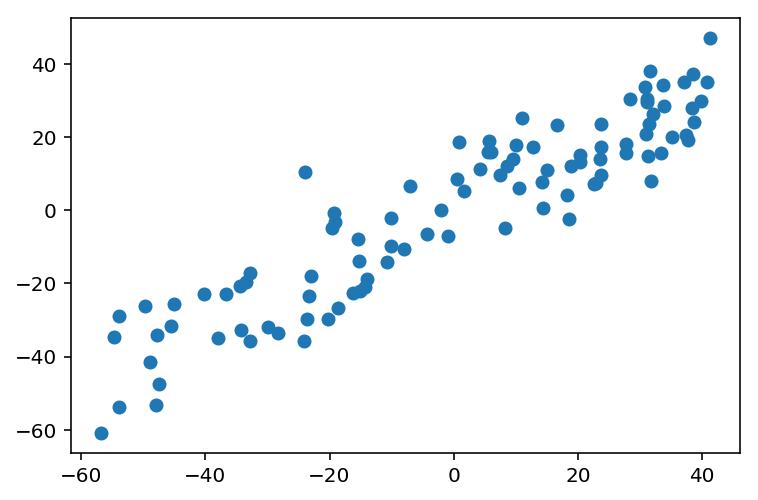

In [11]:
# 去均值的直观效果是我们将数据点移到了原点附近
plt.scatter(X_demean[:, 0], X_demean[:, 1])
plt.show()

此时，我们再计算一下特征的均值。

In [12]:
np.mean(X_demean[:, 0])

-1.9184653865522706e-14

In [13]:
np.mean(X_demean[:, 1])

1.3038459201197838e-14

+ 上面的两个值都很接近 0 ，因为计算机的浮点数计算有误差，说明我们已经完成了去均值。

## 梯度上升法

目标函数的公式是：

$$
\cfrac{1}{m} \sum_{i=1}^{m}(\sum_{j=1}^{n}X_j^{(i)}w_j)^2
$$

解读这个公式：

我们的数据按照矩阵存储，每一行表示一个数据，每一列表示一个特征。

+ $X^{(i)}$，表示一个数据，$X_j^{(i)}$，表示一个数据的第 $j$ 号分量；
+ 对于一个数据而言，有 $n$ 个分量，对应相乘之后求和是 $\sum_{j=1}^{n}X_j^{(i)}w_j^2$；
+ 一共有 $m$ 个数据，就在外面加一个对 $m$ 的求和。 

In [12]:
def f(w, X):
    return np.sum((X.dot(w)**2)) / len(X)


说明：

+ 这里的 $X$ 是一个归零化的矩阵；
+ 这里的 $w$ 是一个列向量，除以数据个数是为了取平均，让方差不随样本数量的变化而变化；
+ 按照数理统计的观点，应该除以 $m - 1$。

### 求梯度向量
梯度向量公式的推导，需要一些纸上的数学运算，这里要动手完成一下。
+ 思路就是把求和变成数量积。

$$
\nabla f = \cfrac{2}{m} \cdot X^{T}(Xw)
$$

In [13]:
def df_math(w, X):
    return X.T.dot(X.dot(w)) * 2 / len(X)

### 万能梯度公式（其实就是梯度的定义，仅仅用于测试梯度的计算）

In [14]:
# 梯度的数学定义，可以认为是一个万能梯度求解算法，但是它的计算量大，只能用于调试，验证我们的梯度公式推导是否正确
def df_debug(w, X, epsilon=0.0001):
    res = np.empty(len(w))
    for i in range(len(w)):
        w_1 = w.copy()
        w_1[i] = w_1[i] + epsilon
        w_2 = w.copy()
        w_2[i] = w_2[i] - epsilon
        res[i] = (f(w_1, X) - f(w_2, X)) / (2 * epsilon)
    return res

因为我们在理论推导的过程中，有一个前提假设 $|w| = 1$，在后续的编码中应保持这一点。

In [15]:
# 向量单位化
def direction(w):
    return w / np.linalg.norm(w)


def gradient_ascent(df, X, initial_w, eta, n_iters=1e4, epsilon=1e-8):
    """
    df：计算在当前取值 X 处的梯度向量，注意保持 w 是单位向量
    X：数据
    
    """
    # 梯度上升一开始就进行向量单位化
    w = direction(initial_w) # 将梯度向量变成单位向量，因为我们只关心方向，空间中一个向量在单位向量上的投影，就是它们的数量积
    cur_iter = 0
    while cur_iter < n_iters:
        # 计算在当前取值 X 处的梯度
        gradient = df(w, X)
        # 记录变化之前的变量值
        last_w = w
        # 梯度上升，所以是加号
        w = w + eta * gradient
        # 迭代的过程中也保持 w 是单位向量
        w = direction(w)
        # 函数值变化不大，则停止
        if(abs(f(w, X) - f(last_w, X)) < epsilon):
            break
        cur_iter += 1
    return w

$w$ 初始的开始的位置不能为**零向量**。因为零向量也能使得梯度为 0，零向量也是目标函数的极值点，只不过是极小值点。

In [16]:
initial_w = np.random.random(X.shape[1])
initial_w

array([ 0.45993709,  0.20275537])

In [17]:
eta = 0.001

+ PCA 要求 demean 只是去均值，没有要求方差要归一。

下面计算一下梯度。看到两者一样，说明计算梯度是没有问题的。

#### 使用梯度计算公式计算梯度完成梯度上升

In [18]:
gradient_ascent(df_debug, X_demean, initial_w, eta)

array([ 0.78263477,  0.62248118])

#### 使用推导的梯度（向量化）计算梯度完成梯度上升

In [19]:
gradient_ascent(df_math, X_demean, initial_w, eta)

array([ 0.78263477,  0.62248118])

+ 二者一样，说明我们的梯度数学解没有问题。

于是我们就求出的第 1 主成分。  
下面我们作图来验证这件事情。

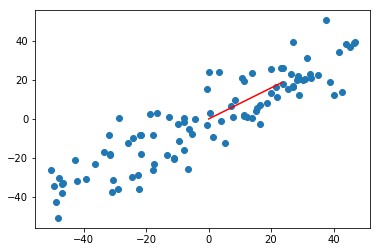

In [24]:
# 使用梯度上升法求出了第 1 主成分
w = gradient_ascent(df_math, X_demean, initial_w, eta)
plt.scatter(X_demean[:, 0], X_demean[:, 1])
plt.plot([0, w[0] * 30], [0, w[1] * 30], color='r')
plt.show()

下面我们测试一个极端的情况，即没有噪声的情况下，做主成分分析，看看求解的单位向量是什么。

In [26]:
X2 = np.empty((100, 2))
X2[:, 0] = np.random.uniform(0., 100., size=100)
X2[:, 1] = 0.75 * X2[:, 0] + 3.

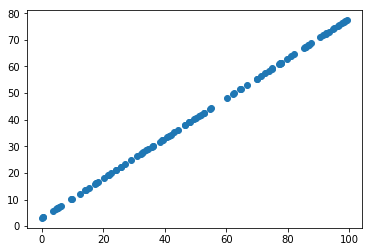

In [28]:
plt.scatter(X2[:, 0], X2[:, 1])
plt.show()

In [33]:
X2_demean = demean(X2)

In [35]:
gradient_ascent(df_math, X2_demean, initial_w, eta)

array([ 0.80000024,  0.59999968])

In [37]:
w2 = gradient_ascent(df_math, X2_demean, initial_w, eta)

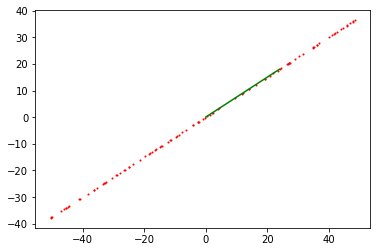

In [49]:
plt.scatter(X2_demean[:, 0], X2_demean[:, 1], color='r', s=1)
plt.plot([0, w2[0] * 30], [0, w2[1] * 30], color='g')
plt.show()

---

## 如何得到一个矩阵的某一列呢？

一个矩阵的某一列，一定包含了这个矩阵中每一行的其中一个元素。所以，使用切片的方法，应该先获得矩阵的每一行。

In [14]:
a = np.arange(18).reshape(3, 6)
a

array([[ 0,  1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10, 11],
       [12, 13, 14, 15, 16, 17]])

In [15]:
# 得到矩阵的第 2 列
a[:, 1]

array([ 1,  7, 13])

## 如何得到一个矩阵的某一行呢？

In [16]:
a[2]

array([12, 13, 14, 15, 16, 17])

In [17]:
a[2, :]

array([12, 13, 14, 15, 16, 17])